In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import State
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

# Compare values down to 3rd digit
precision = 3

# Defining the network structure
weather = BayesianModel([('Cloudy', 'Rain'), ('Cloudy', 'Sprinkler'), ('Sprinkler', 'WetGrass'), ('Rain', 'WetGrass')])

# Defining the CPDs:
cpd_cloudy = TabularCPD('Cloudy', 2, [[.5],[.5]])
cpd_sprinkler = TabularCPD('Sprinkler', 2, [[.1,.5],[.9,.5]], evidence = ['Cloudy'], evidence_card=[2])
cpd_rain = TabularCPD('Rain', 2, [[.8,.2],[.2,.8]], evidence = ['Cloudy'], evidence_card=[2])
cpd_wetgrass = TabularCPD('WetGrass', 2, [[.99,.9,.9,.01],[.01,.1,.1,.99]], evidence = ['Sprinkler','Rain'], evidence_card=[2,2])

weather.add_cpds(cpd_cloudy,cpd_sprinkler,cpd_rain,cpd_wetgrass)
# weather.get_cpds()
weather.check_model()

# Exact values of queries (for comparison)
inference = VariableElimination(weather)
pcloudy = inference.query(['Cloudy'],{'Sprinkler':1,'WetGrass':1}).values[1]
print('P(Cloudy=true|Sprinkler=true,WetGrass=true) = ', round(pcloudy,precision))
prain = inference.query(['Rain'],{'Sprinkler':1,'WetGrass':1}).values[1]
print('P(Rain=true|Sprinkler=true,WetGrass=true) = ', round(prain,precision))


P(Cloudy=true|Sprinkler=true,WetGrass=true) =  0.619
P(Rain=true|Sprinkler=true,WetGrass=true) =  0.875


c:\Users\aeste\anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [13]:
print(cpd_rain)
print(cpd_cloudy)
print(cpd_sprinkler)
print(cpd_wetgrass)

+---------+-----------+-----------+
| Cloudy  | Cloudy(0) | Cloudy(1) |
+---------+-----------+-----------+
| Rain(0) | 0.8       | 0.2       |
+---------+-----------+-----------+
| Rain(1) | 0.2       | 0.8       |
+---------+-----------+-----------+
+-----------+-----+
| Cloudy(0) | 0.5 |
+-----------+-----+
| Cloudy(1) | 0.5 |
+-----------+-----+
+--------------+-----------+-----------+
| Cloudy       | Cloudy(0) | Cloudy(1) |
+--------------+-----------+-----------+
| Sprinkler(0) | 0.1       | 0.5       |
+--------------+-----------+-----------+
| Sprinkler(1) | 0.9       | 0.5       |
+--------------+-----------+-----------+
+-------------+--------------+--------------+--------------+--------------+
| Sprinkler   | Sprinkler(0) | Sprinkler(0) | Sprinkler(1) | Sprinkler(1) |
+-------------+--------------+--------------+--------------+--------------+
| Rain        | Rain(0)      | Rain(1)      | Rain(0)      | Rain(1)      |
+-------------+--------------+--------------+------------

In [ ]:
def Enumeration(X, e, model: BayesianModel):
    Q = []
    for value in X:

In [2]:
# Now switch to sampling methods
inference = BayesianModelSampling(weather)
evidence = [State('WetGrass', 1),State('Sprinkler', 1)]
verbose = False

def prob_LW(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def relative_error(exact_value,approx_value):
    return np.absolute((exact_value-approx_value)/exact_value)

def absolute_error(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)

def run_experiment(sample_size):
    # Sample
    samples_LW = inference.likelihood_weighted_sample(evidence = evidence, size=sample_size)
    samples_RS = inference.rejection_sample(evidence=evidence, size=sample_size)

    # Statistics
    pcloudy_LW=prob_LW(samples_LW,'Cloudy')
    prain_LW=prob_LW(samples_LW,'Rain')
    pcloudy_RS=np.mean(samples_RS['Cloudy'], axis=0)
    prain_RS=np.mean(samples_RS['Rain'], axis=0)
    
    # Reporting
    if(verbose):
        print()
        print("P(Cloudy=true|Sprinkler=true,WetGrass=true) =", round(pcloudy,precision))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, pcloudy_RS, absolute_error(pcloudy,pcloudy_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, pcloudy_LW, absolute_error(pcloudy,pcloudy_LW)*100))
        print()
        print("P(Rain=true|Sprinkler=true,WetGrass=true) =", round(prain,precision))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, prain_RS, absolute_error(prain,prain_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, prain_LW, absolute_error(prain,prain_LW)*100))
    
    # Return results
    return np.array([(sample_size, 
                      pcloudy_RS, absolute_error(pcloudy,pcloudy_RS),
                      pcloudy_LW, absolute_error(pcloudy,pcloudy_LW),
                      prain_RS, absolute_error(prain,prain_RS),
                      prain_LW, absolute_error(prain,prain_LW))], 
                    dtype=[('sample_size', '<i8'), 
                           ('pcloudy_RS', '<f8'),('e_pcloudy_RS', '<f8'),
                           ('pcloudy_LW', '<f8'),('e_pcloudy_LW', '<f8'),
                           ('prain_RS', '<f8'),('e_prain_RS', '<f8'),
                           ('prain_LW', '<f8'),('e_prain_LW', '<f8')])

# To view samples
# print(samples_LW)
# samples_LW.view()
# print(samples_RS[:5]), print(' ... '), print(samples_RS[nsamples_RS-5:])

In [3]:
results = np.array([],dtype=[('sample_size', '<i8'), 
                             ('pcloudy_RS', '<f8'),('e_pcloudy_RS', '<f8'),
                             ('pcloudy_LW', '<f8'),('e_pcloudy_LW', '<f8'),
                             ('prain_RS', '<f8'),('e_prain_RS', '<f8'),
                             ('prain_LW', '<f8'),('e_prain_LW', '<f8')])
starting_size_=1 # from 10 sample points
final_size=5     # to 10^5 sample points
experiments=20 # 8 experiments

for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size))
    
print(results)

100%|██████████| 100000/100000 [00:01<00:00, 95796.02it/s]

[(    10, 0.4       , 0.21871381, 0.51, 0.10871381, 0.9       , 2.49619019e-02, 0.93, 0.0549619)
 (    16, 0.6875    , 0.06878619, 0.95, 0.33128619, 0.8125    , 6.25380981e-02, 0.94, 0.0649619)
 (    26, 0.69230769, 0.07359389, 0.67, 0.05128619, 0.88461538, 9.57728647e-03, 0.87, 0.0050381)
 (    42, 0.71428571, 0.09557191, 0.71, 0.09128619, 0.88095238, 5.91428281e-03, 0.84, 0.0350381)
 (    69, 0.5942029 , 0.02451091, 0.64, 0.02128619, 0.91304348, 3.80053801e-02, 0.84, 0.0350381)
 (   112, 0.61607143, 0.00264238, 0.61, 0.00871381, 0.88392857, 8.89047329e-03, 0.91, 0.0349619)
 (   183, 0.62295082, 0.00423701, 0.54, 0.07871381, 0.87431694, 7.21158250e-04, 0.87, 0.0050381)
 (   297, 0.55892256, 0.05979125, 0.58, 0.03871381, 0.85858586, 1.64522396e-02, 0.87, 0.0050381)
 (   483, 0.64803313, 0.02931932, 0.64, 0.02128619, 0.88198758, 6.94947950e-03, 0.88, 0.0049619)
 (   784, 0.63137755, 0.01266374, 0.59, 0.02871381, 0.88265306, 7.61496308e-03, 0.88, 0.0049619)
 (  1274, 0.60753532, 0.011178

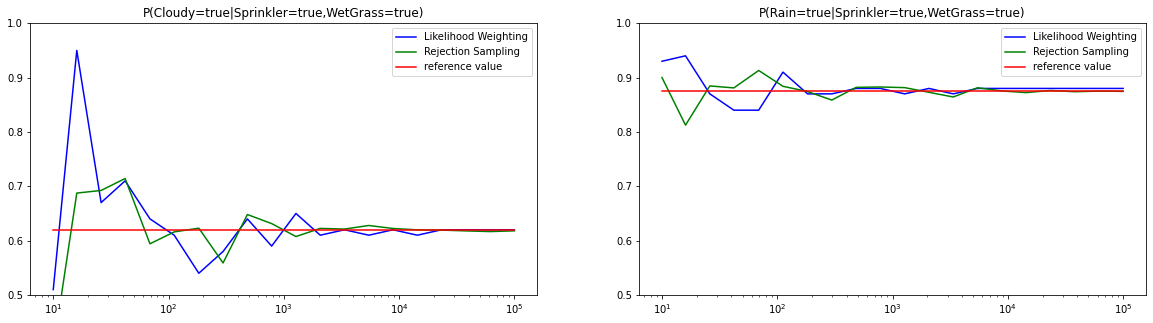

In [4]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0.5,1)
plt.title('P(Cloudy=true|Sprinkler=true,WetGrass=true)')
LWCplot, = plt.semilogx(results['sample_size'],results['pcloudy_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['pcloudy_RS'],'g',label="Rejection Sampling")
VECplot, = plt.semilogx(results['sample_size'],pcloudy*np.ones(results.size),'r',label="reference value")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.subplot(122)
plt.ylim(0.5,1)
plt.title('P(Rain=true|Sprinkler=true,WetGrass=true)')
LWCplot, = plt.semilogx(results['sample_size'],results['prain_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['prain_RS'],'g',label="Rejection Sampling")
VECplot, = plt.semilogx(results['sample_size'],prain*np.ones(results.size),'r',label="reference value")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.show()

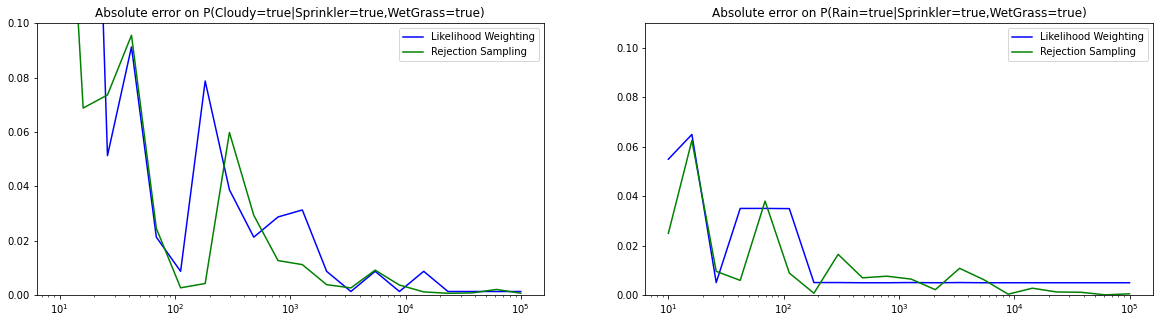

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0,.1)
plt.title('Absolute error on P(Cloudy=true|Sprinkler=true,WetGrass=true)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_pcloudy_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_pcloudy_RS'],'g',label="Rejection Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.subplot(122)
plt.ylim(0,.11)
plt.title('Absolute error on P(Rain=true|Sprinkler=true,WetGrass=true)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_prain_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_prain_RS'],'g',label="Rejection Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.show()

In [6]:
weather.get_markov_blanket('Cloudy')

['Rain', 'Sprinkler']

In [7]:
weather.get_markov_blanket('Rain')

['Cloudy', 'WetGrass', 'Sprinkler']